## shock-cooling

In this tutorial, we present all the functionality available in shock_cooling_curve and how it can be used to model early time signatures from supernovae using one of the analytical models presented for shock cooling emission.

In [1]:
import shock_cooling_curve.supernova

from shock_cooling_curve.models import PIRO_2015, PIRO_2020, SW_BSG, SW_RSG

from shock_cooling_curve.fitter import Fitter
from shock_cooling_curve.plotter import Plotter


In [2]:
test_model = PIRO_2020.PIRO_2020('config.ini', 'data/2021gno/')

In [3]:
fit_test_model = Fitter(test_model)

In [4]:
curve_fit_results = fit_test_model.simple_curve_fit()

In [5]:
curve_fit_results

(array([1.25438820e+02, 1.98077474e-01, 4.74989340e-01, 8.50062522e-20]),
 array([5.84058971e+01, 8.66735338e+05, 2.96918464e+05, 1.95641136e-01]))

In [6]:
fit_test_model.display_curve_fit()

Piro (2020) model for  simple curve fitted values:
re: 1.254388e+02 +/- 5.840590e+01 R_sun
me: 1.980775e-01 +/- 8.667353e+05 M_sun
ve: 4.749893e-01 +/- 2.969185e+05 1e9 cm/s
Off: 8.500625e-20 +/- 1.956411e-01 days


,PIRO_2020 value,PIRO_2020 error
re (R_sun),1.254388e+02,58.405897
me (M_sun),1.980775e-01,866735.338224
ve (1e9 cm/s),4.749893e-01,296918.463767
Off (days),8.500625e-20,0.195641


In [7]:
BSG_low = [0.01, 0.01, 0.01, 0.01]
BSG_high = [2, 2, 4, 0.5]

RSG_low = [0.01, 0.01, 0.01, 0.01]
RSG_high = [1, 2, 3, 0.8]

P15_low = [0.1, 0.01, 0.001]
P15_high = [100, 1, 1]

P20_low = [0.1, 0.01, 0.01, 0.01]
P20_high = [500, 1, 10, 0.2]

In [8]:
fit_test_model._loglikelihood_gauss(p = curve_fit_results[0], xdata = fit_test_model.xdata_phase, 
ydata = fit_test_model.ydata_mag, yerr = fit_test_model.yerr_mag)

-1732.3007228743372

In [9]:
mcmc_results = fit_test_model.MCMC_fit(prior_low = P20_low, prior_high = P20_high, 
nwalkers=50, nsteps=3000, sigma=1, minimize_param_space=False)

  0%|          | 0/3000 [00:00<?, ?it/s]/Users/padmavenkatraman/Documents/Supernovae/SC_Modeling/SC_Notebooks/shock-cooling/shockcool/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 3000/3000 [00:00<00:00, 3238.90it/s]


In [10]:
plot_test_model = Plotter(test_model)

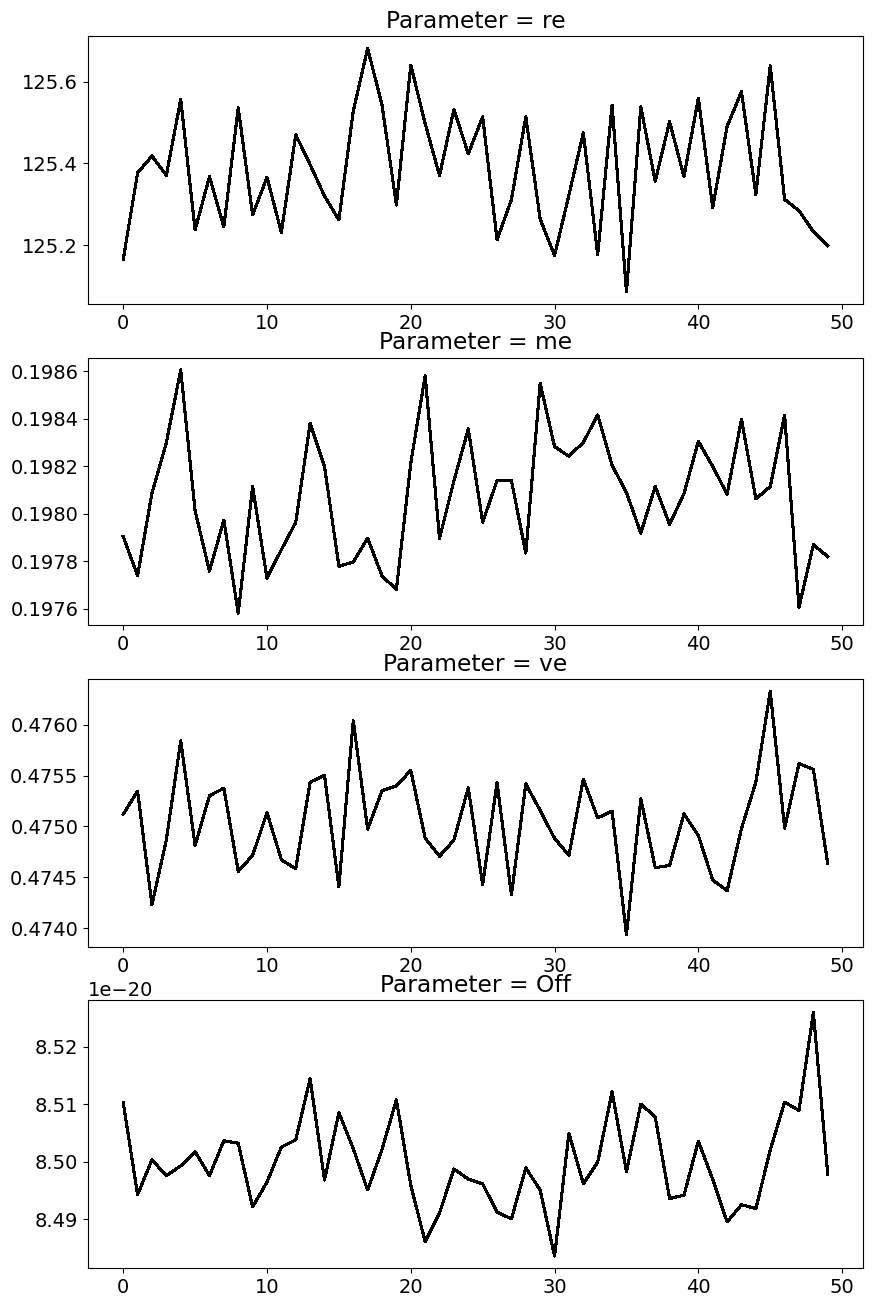

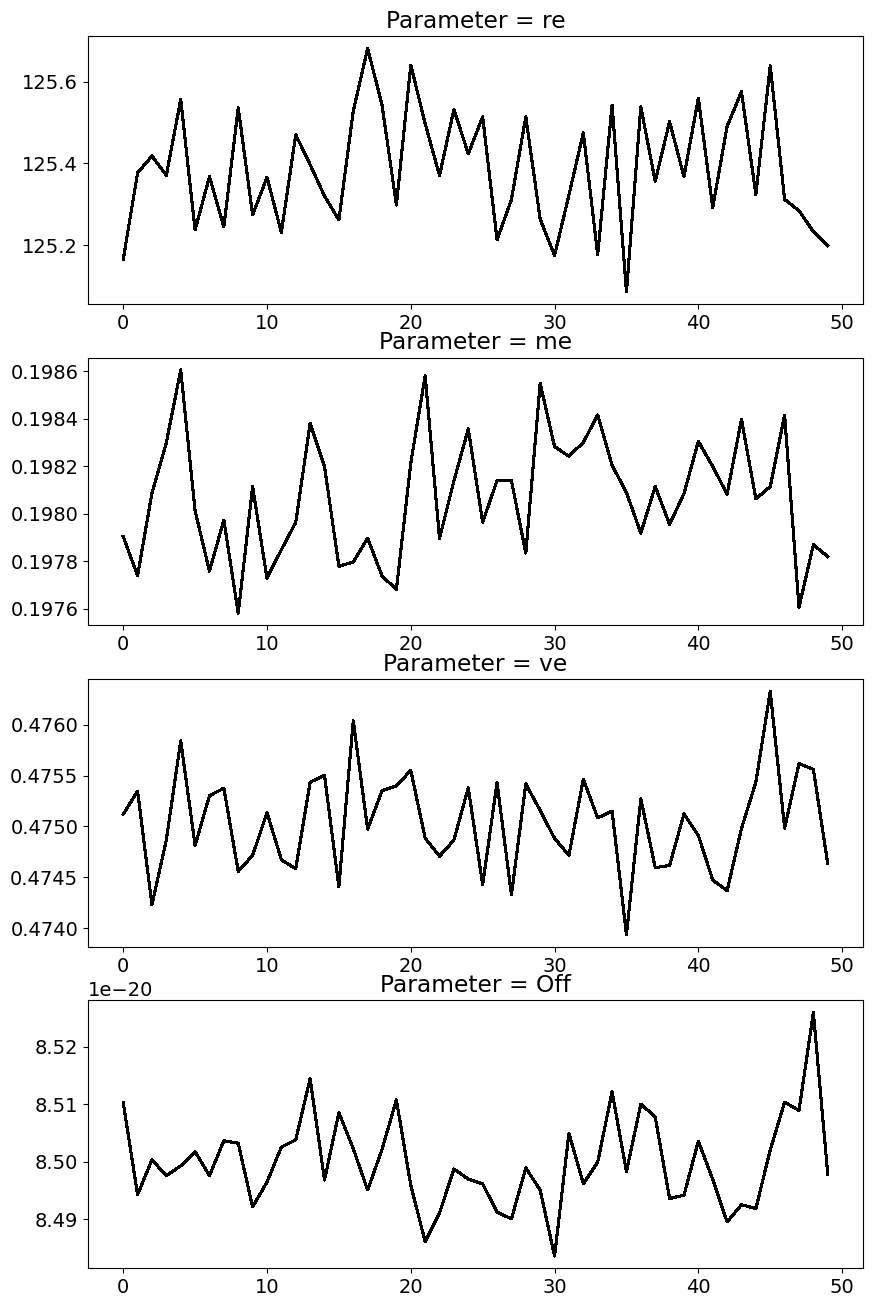

In [11]:
plot_test_model.MCMC_trace()

TypeError: can't multiply sequence by non-int of type 'float'

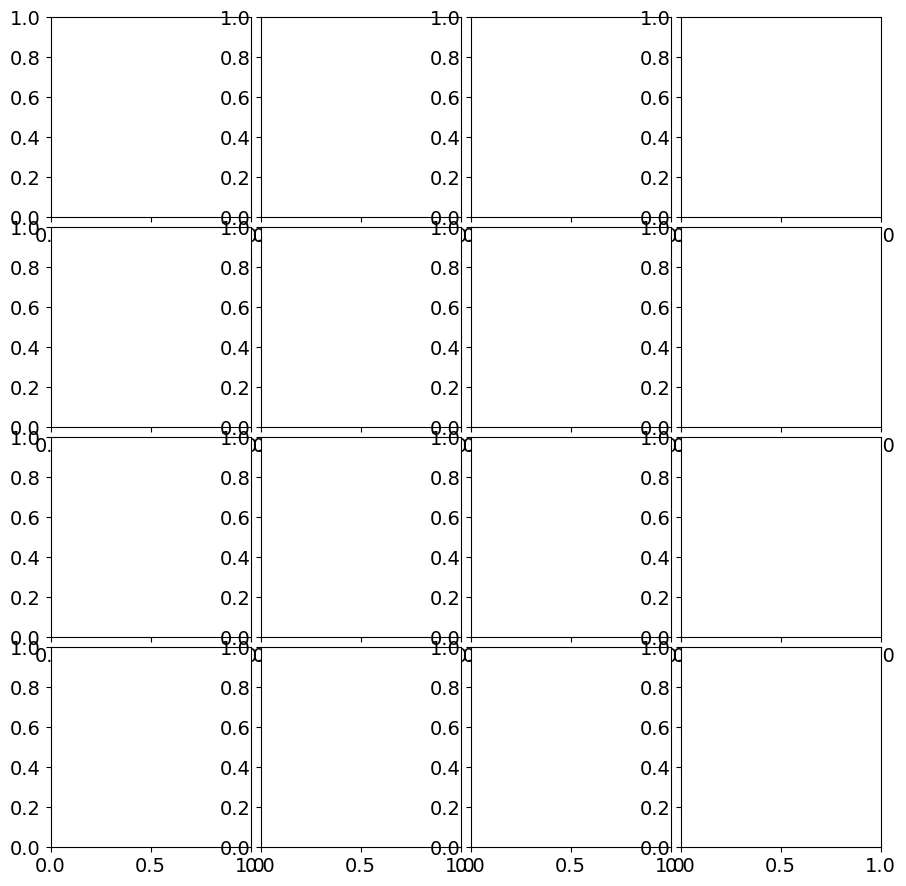

In [12]:
plot_test_model.MCMC_corner()

In [17]:
import corner as cn

In [20]:
samples = plot_test_model.sn_obj.samp_chain[:, 100:, :].reshape((-1, plot_test_model.n_params))

TypeError: can't multiply sequence by non-int of type 'float'

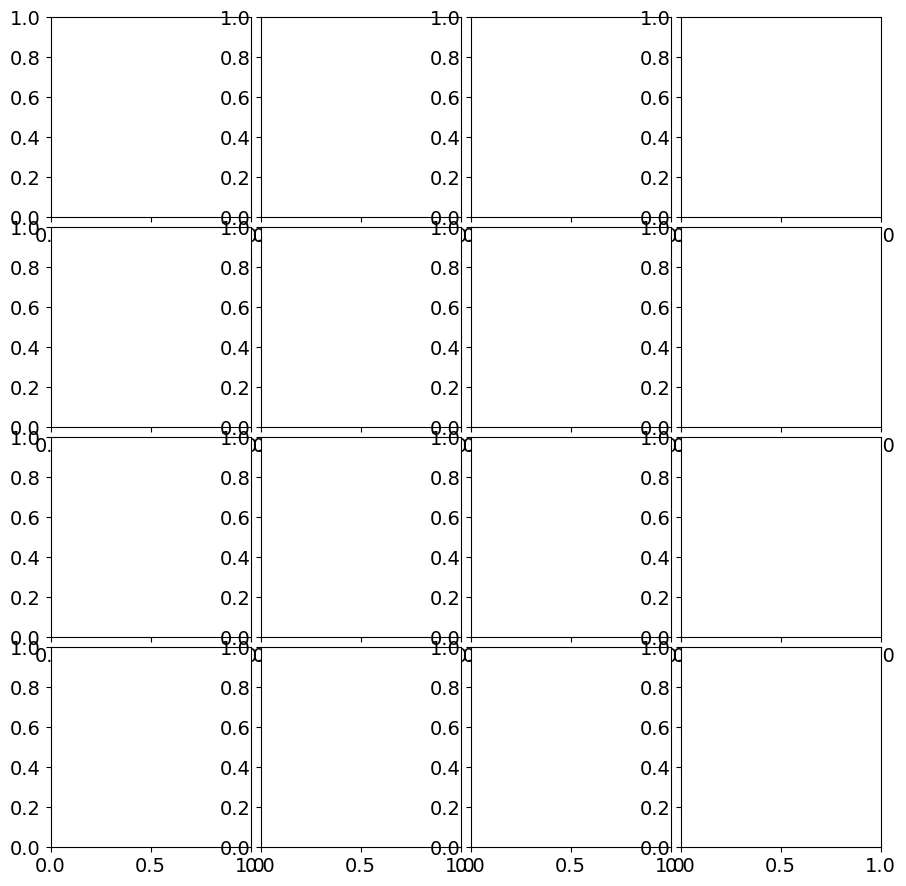

In [21]:
fig = cn.corner(
samples,
["re", "me", "ve", "off"],
quantiles=[0.16, 0.5, 0.84],
show_titles=True,
title_kwargs={"fontsize": 12, "loc": "left"}
)
